In [1]:
import numpy as np
np.random.seed(123)

- 데이터 로딩

In [2]:
from tensorflow.keras.datasets import boston_housing

(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

In [3]:
x_train[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

In [4]:
y_train[0]

15.2

- 데이터 표준화

In [5]:
train_mean = x_train.mean(axis=0)
x_train -= train_mean
train_std = x_train.std(axis=0)
x_train /= train_std

x_test -= train_mean
x_test /= train_std
x_train[0]

array([-0.27224633, -0.48361547, -0.43576161, -0.25683275, -0.1652266 ,
       -0.1764426 ,  0.81306188,  0.1166983 , -0.62624905, -0.59517003,
        1.14850044,  0.44807713,  0.8252202 ])

- 모델 정의

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [7]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                896       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


In [8]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


- 컴파일을 포함한 모델 생성 함수 정의

In [9]:
def build_model():
    model = models.Sequential()
    model.add(Dense(64, activation='relu', input_shape=(x_train.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

- K-Fold Cross Validation (k=4, epochs=100)

In [10]:
k = 4

In [11]:
num_val_sample = len(x_train) // k
num_epochs = 100
all_scores = []

In [12]:
for i in range(k):
    print('처리중인 폴드 : #', i+1)
    x_val = x_train[(i * num_val_sample) : ((i+1) * num_val_sample)]
    y_val = y_train[(i * num_val_sample) : ((i+1) * num_val_sample)]
    
    p_x_train = np.concatenate(
        [x_train[:(i * num_val_sample)],
         x_train[((i+1) * num_val_sample):]], axis=0)
    p_y_train = np.concatenate(
        [y_train[:(i * num_val_sample)],
         y_train[((i+1) * num_val_sample):]], axis=0)
    
    model = build_model()
    model.fit(p_x_train, p_y_train, epochs = num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(x_val, y_val, verbose=0)
    all_scores.append(val_mae)

처리중인 폴드 : # 1
처리중인 폴드 : # 2
처리중인 폴드 : # 3
처리중인 폴드 : # 4


In [13]:
all_scores

[2.3823330402374268, 2.753225803375244, 2.607408285140991, 2.561948299407959]

In [14]:
np.mean(all_scores)

2.5762288570404053

- K-Fold Cross Validation (k=4, epochs=500)

In [15]:
k=4
num_epochs = 500
all_scores = []

for i in range(k):
    print('처리중인 폴드 : #', i+1)
    x_val = x_train[(i * num_val_sample) : ((i+1) * num_val_sample)]
    y_val = y_train[(i * num_val_sample) : ((i+1) * num_val_sample)]
    
    p_x_train = np.concatenate(
        [x_train[:(i * num_val_sample)],
         x_train[((i+1) * num_val_sample):]], axis=0)
    p_y_train = np.concatenate(
        [y_train[:(i * num_val_sample)],
         y_train[((i+1) * num_val_sample):]], axis=0)
    
    model = build_model()
    history = model.fit(p_x_train, p_y_train,
                        validation_data=(x_val, y_val),
                        epochs = num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_scores.append(mae_history)

처리중인 폴드 : # 1
처리중인 폴드 : # 2
처리중인 폴드 : # 3
처리중인 폴드 : # 4


In [16]:
mean_all_scores = [np.mean([x[i] for x in all_scores]) for i in range(num_epochs)]

- 결과 시각화

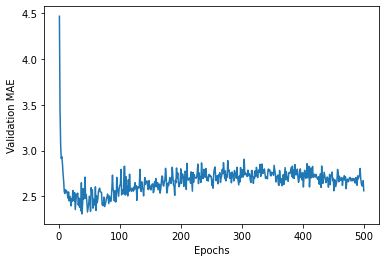

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1, len(mean_all_scores)+1), mean_all_scores)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE');

- Smoothing Curve를 사용한 시각화

In [18]:
def smooth_curve(points, factor=0.1):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            pre = smoothed_points[-1]
            smoothed_points.append(pre * (1-factor) + point * factor)
        else:
            smoothed_points.append(point)
    return smoothed_points

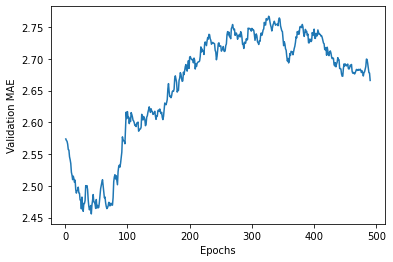

In [19]:
smoothed_mae = smooth_curve(mean_all_scores[10:])

plt.plot(range(1, len(smoothed_mae)+1), smoothed_mae)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE');

- 최종 모델

In [20]:
model = build_model()
model.fit(x_train, y_train, epochs=80, batch_size=16)

Epoch 1/80
26/26 [==============================] - 0s 3ms/step - loss: 568.3090 - mae: 22.0745
Epoch 2/80
26/26 [==============================] - 0s 3ms/step - loss: 379.5851 - mae: 17.4988
Epoch 3/80
26/26 [==============================] - 0s 3ms/step - loss: 213.2382 - mae: 12.0822
Epoch 4/80
26/26 [==============================] - 0s 3ms/step - loss: 95.3034 - mae: 7.2484
Epoch 5/80
26/26 [==============================] - 0s 3ms/step - loss: 71.4740 - mae: 6.0245
Epoch 6/80
26/26 [==============================] - 0s 3ms/step - loss: 41.6978 - mae: 4.7345
Epoch 7/80
26/26 [==============================] - 0s 3ms/step - loss: 26.4638 - mae: 3.8658
Epoch 8/80
26/26 [==============================] - 0s 3ms/step - loss: 25.4185 - mae: 3.6144
Epoch 9/80
26/26 [==============================] - 0s 3ms/step - loss: 25.0057 - mae: 3.4391
Epoch 10/80
26/26 [==============================] - 0s 3ms/step - loss: 20.0132 - mae: 3.1231
Epoch 11/80
26/26 [==============================] - 

In [21]:
results = model.evaluate(x_test, y_test)
results

4/4 [==============================] - 0s 2ms/step - loss: 14.7820 - mae: 2.6687


[14.782025337219238, 2.6687188148498535]